In [289]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point

In [290]:
endpoint = "https://data.nashville.gov/resource/2u6v-ujjs.json?$limit=50000"

params = {'$where' : "incident_reported between '2021-01-13T00:00:00.000' and '2021-06-30T00:00:00.000'", 
}

In [315]:
response = requests.get(endpoint, params)
response

requests.models.Response

In [292]:
res = response.json()
res = pd.DataFrame(res, columns=['incident_reported', 'offense_description', 'latitude', 'longitude', 'zip_code'])
res['date_reported'] = res['incident_reported'].str.split("T", expand=True)[0]
res_trimmed = res.drop(columns='incident_reported')
burglary_reports = res_trimmed[res_trimmed['offense_description'].str.contains('BURGLARY- AGGRAVATED')]
burglary_reports

,offense_description,latitude,longitude,zip_code,date_reported
199,BURGLARY- AGGRAVATED,36.06,-86.95,NaN,2021-01-13
310,BURGLARY- AGGRAVATED,36.19,-86.75,NaN,2021-01-14
434,BURGLARY- AGGRAVATED,36.18,-86.75,NaN,2021-01-14
450,BURGLARY- AGGRAVATED,36.04,-86.73,NaN,2021-01-14
495,BURGLARY- AGGRAVATED,36.16,-86.85,NaN,2021-01-14
...,...,...,...,...,...
48579,BURGLARY- AGGRAVATED,36.21,-86.83,NaN,2021-06-29
48606,BURGLARY- AGGRAVATED,36.178,-86.598,37076,2021-06-29
48715,BURGLARY- AGGRAVATED,36.16,-86.8,NaN,2021-06-29
48806,BURGLARY- AGGRAVATED,36.04,-86.66,NaN,2021-06-29


In [293]:
burglary_reports[['latitude', 'longitude']] = burglary_reports[['latitude', 'longitude']].apply(pd.to_numeric);

burglary_reports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 199 to 48866
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   offense_description  984 non-null    object 
 1   latitude             982 non-null    float64
 2   longitude            982 non-null    float64
 3   zip_code             145 non-null    object 
 4   date_reported        984 non-null    object 
dtypes: float64(2), object(3)
memory usage: 46.1+ KB


C:\Users\Conrad\anaconda3\envs\geospatial\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [294]:
census_tract = gpd.read_file('data/tl_2019-47_tract/tl_2019_47_tract.shp')
type(census_tract)

geopandas.geodataframe.GeoDataFrame

In [295]:
print(census_tract.crs)
census_tract.head()

epsg:4269


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."


In [296]:
#leg_kwds = {'title': 'Census Tracts', 'loc':'upper left', 
#            'bbox_to_anchor': (0, 0), 'ncol': 9}

#census_tract.plot(column = 'NAME', figsize=(15, 15), edgecolor = 'black',
#                 legend = True, legend_kwds = leg_kwds, cmap = 'terrain')

In [297]:
burglary_reports['geometry'] = burglary_reports.apply(lambda x: Point((x.longitude,
                                                                      x.latitude)),
                                                     axis=1)

burglary_reports

C:\Users\Conrad\AppData\Local\Temp/ipykernel_27716/2041210830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burglary_reports['geometry'] = burglary_reports.apply(lambda x: Point((x.longitude,


,offense_description,latitude,longitude,zip_code,date_reported,geometry
199,BURGLARY- AGGRAVATED,36.060,-86.950,NaN,2021-01-13,POINT (-86.95 36.06)
310,BURGLARY- AGGRAVATED,36.190,-86.750,NaN,2021-01-14,POINT (-86.75 36.19)
434,BURGLARY- AGGRAVATED,36.180,-86.750,NaN,2021-01-14,POINT (-86.75 36.18)
450,BURGLARY- AGGRAVATED,36.040,-86.730,NaN,2021-01-14,POINT (-86.73 36.04)
495,BURGLARY- AGGRAVATED,36.160,-86.850,NaN,2021-01-14,POINT (-86.84999999999999 36.16)
...,...,...,...,...,...,...
48579,BURGLARY- AGGRAVATED,36.210,-86.830,NaN,2021-06-29,POINT (-86.83 36.21)
48606,BURGLARY- AGGRAVATED,36.178,-86.598,37076,2021-06-29,POINT (-86.598 36.178)
48715,BURGLARY- AGGRAVATED,36.160,-86.800,NaN,2021-06-29,POINT (-86.8 36.16)
48806,BURGLARY- AGGRAVATED,36.040,-86.660,NaN,2021-06-29,POINT (-86.66 36.04)


In [298]:
burglary_geo = gpd.GeoDataFrame(burglary_reports,
                               crs=census_tract.crs,
                               geometry = burglary_reports['geometry'])

In [299]:
census_tract = census_tract[['COUNTYFP', 'NAME', 'geometry']]
#census_tract['COUNTYFP'] = census_tract['COUNTYFP'].apply(pd.to_numeric)
#census_tract = census_tract[census_tract['COUNTYFP'] == 37]

In [300]:
burglary_by_tract = gpd.sjoin(burglary_geo, census_tract, op = 'within')

In [301]:
burglary_by_tract.drop_duplicates(subset='geometry', inplace=True)
burglary_by_tract

,offense_description,latitude,longitude,zip_code,date_reported,geometry,index_right,COUNTYFP,NAME
199,BURGLARY- AGGRAVATED,36.060,-86.950,NaN,2021-01-13,POINT (-86.95000 36.06000),569,037,184.07
14375,BURGLARY- AGGRAVATED,36.070,-86.990,NaN,2021-03-05,POINT (-86.99000 36.07000),569,037,184.07
310,BURGLARY- AGGRAVATED,36.190,-86.750,NaN,2021-01-14,POINT (-86.75000 36.19000),570,037,117
2779,BURGLARY- AGGRAVATED,36.190,-86.740,NaN,2021-01-22,POINT (-86.74000 36.19000),570,037,117
434,BURGLARY- AGGRAVATED,36.180,-86.750,NaN,2021-01-14,POINT (-86.75000 36.18000),591,037,119
...,...,...,...,...,...,...,...,...,...
45214,BURGLARY- AGGRAVATED,36.210,-86.710,NaN,2021-06-18,POINT (-86.71000 36.21000),557,037,115
46034,BURGLARY- AGGRAVATED,36.161,-86.626,37214,2021-06-20,POINT (-86.62600 36.16100),714,037,155.01
47218,BURGLARY- AGGRAVATED,36.198,-86.602,37076,2021-06-24,POINT (-86.60200 36.19800),567,037,154.05
47463,BURGLARY- AGGRAVATED,36.330,-86.730,NaN,2021-06-25,POINT (-86.73000 36.33000),1087,037,103.01


In [302]:
census_tract_names = burglary_by_tract['NAME']
census_tract_names = pd.DataFrame(census_tract_names)
polygon_nash = pd.merge(census_tract, census_tract_names, on = 'NAME')
polygon_nash.drop_duplicates(subset='NAME')

,COUNTYFP,NAME,geometry
0,037,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
2,037,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
10,037,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."
14,037,181.02,"POLYGON ((-86.88737 36.11771, -86.88733 36.117..."
16,031,9801,"POLYGON ((-86.15980 35.36284, -86.15978 35.362..."
...,...,...,...
515,037,189.04,"POLYGON ((-86.73805 36.06626, -86.73780 36.066..."
517,037,189.05,"POLYGON ((-86.74457 36.05547, -86.74447 36.055..."
518,037,136.01,"POLYGON ((-86.84383 36.16325, -86.84375 36.163..."
522,037,183.01,"POLYGON ((-87.03820 36.09382, -87.03819 36.093..."


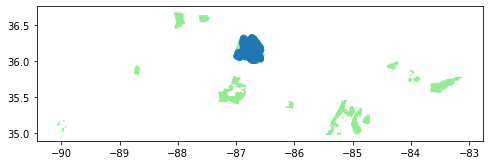

In [303]:
ax = polygon_nash.plot(figsize = (8, 10), color = 'lightgreen')
burglary_by_tract.plot(ax = ax, column = 'offense_description')
plt.show();

In [308]:
with open('data/data_census.json') as fi:
    credentials = json.load(fi)
       
api_key = credentials['api_key']


In [331]:
endpoint = "https://api.census.gov/data/2019/acs/acs5?get=NAME,B01001_001E&for=tract:020100&in=state:47%20county:037$"

params = {
    'key' : api_key
}

In [333]:
response = requests.get(endpoint, params)
response

<Response [200]>

In [334]:
response.json()

JSONDecodeError: Expecting value: line 2 column 1 (char 1)